In [1]:
from utils import load_data
from utils import analyze_chunks
import numpy as np
import pandas as pd
import time
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

# for artificial dataset
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE # doctest: +NORMALIZE_WHITESPACE
from pywt import wavedec

from generate_samples import create_random_X_Y
from random_forest_peaks import generate_x_and_y
from random_forest_peaks import read_file
from random_forest_peaks import SIZES_CONTROL
from random_forest_peaks import SIZES_DISEASE
import collections

Pytorch device: cuda


In [2]:
import json
from itertools import product

def transition_matrix(arr, n=1):
    
    n_maps = list(map(str, list(set(arr))))
    """"
    Computes the transition matrix from Markov chain sequence of order `n`.

    :param arr: Discrete Markov chain state sequence in discrete time with states in 0, ..., N
    :param n: Transition order
    """
    trans_M = collections.defaultdict(lambda: collections.defaultdict(int))
    total = 0
    for i in range(len(arr)-n):
        A = "".join(map(str, arr[i:i+n]))
        B = str(arr[i+n])
        trans_M[A][B] += 1
        total += 1
    #print(trans_M)
    # now I need to create an ordered dictionary 
    full_trans_M = collections.OrderedDict()
    
    for perm in product(n_maps, repeat = n):
        perm = "".join(list(perm))
        for state in n_maps:
            if perm in trans_M: 
                if state in trans_M[perm]:
                    if perm not in full_trans_M:
                        full_trans_M[perm] = collections.OrderedDict({k:0.0 for k in n_maps})
                    full_trans_M[perm][state] = trans_M[perm][state]/total
            else:
                full_trans_M[perm] = collections.OrderedDict({k:0.0 for k in n_maps})
            
    # convert dictionry of dictionary to list 
    X = []
    for key in full_trans_M:
        for key2 in full_trans_M[key]:
            X.append(full_trans_M[key][key2])
    return X
print(transition_matrix([1,3,4,1,2,3,4,1,2,3,4], n=2))

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.2222222222222222, 0.0, 0.0, 0.0, 0.0, 0.1111111111111111, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.2222222222222222, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.2222222222222222, 0.0, 0.0, 0.0, 0.0, 0.2222222222222222, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [38]:

artificial = False
markov = False
filepath =  "D:\\pd_data\\sample_peaks_4.npy"

if not markov:
    chunk_size = 100
    if not artificial:
        X,Y = load_data(filepath, chunk_size, skip=1)
        # we are removing duplicates here
        X,Y = analyze_chunks(X, Y)
        X = np.array(X)
    else:
        num_samples = 100000
        X,Y = create_random_X_Y(num_samples, chunk_size, 2,4)

    new_X = []
    for x in X:
        coeffs = wavedec(x, 'db1', level=2)
        new_coeffs = coeffs[0].flatten()
        for coeff in coeffs[1:]:
            new_coeffs = np.concatenate((new_coeffs, coeff.flatten()))
        new_X.append(new_coeffs)

    X = np.array(new_X)
    Y = np.array(Y)
else:
    microstates = read_file(filepath)
    result = [transition_matrix(sample, n=0) for sample in microstates]
    print(result)
    X = np.array([transition_matrix(sample, n=0) for sample in microstates])
    Y = np.array([0]*len(SIZES_CONTROL) + [1]*len(SIZES_DISEASE))
    
    
print(X.shape, Y.shape)

feat_cols = [ 'pixel'+str(i) for i in range(X.shape[1]) ]
df = pd.DataFrame(X,columns=feat_cols)
df['y'] = Y
df['label'] = df['y'].apply(lambda i: str(i))
print('Size of the dataframe: {}'.format(df.shape))

(68,)
Number of Chunks: 277788
Number of Similar Chunks: 0
Number of Unique Chunks Class One: 97013
Number of Unique Chunks Class Two: 180775
Number of unique chunks: 277788
(277788, 100) (277788,)
Size of the dataframe: (277788, 102)


In [32]:
# lets try PCA 
pca = PCA(n_components=3)
pca_result = pca.fit_transform(df[feat_cols].values)
df['pca-one'] = pca_result[:,0]
df['pca-two'] = pca_result[:,1] 
df['pca-three'] = pca_result[:,2]
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [0.02604218 0.015811   0.01497076]


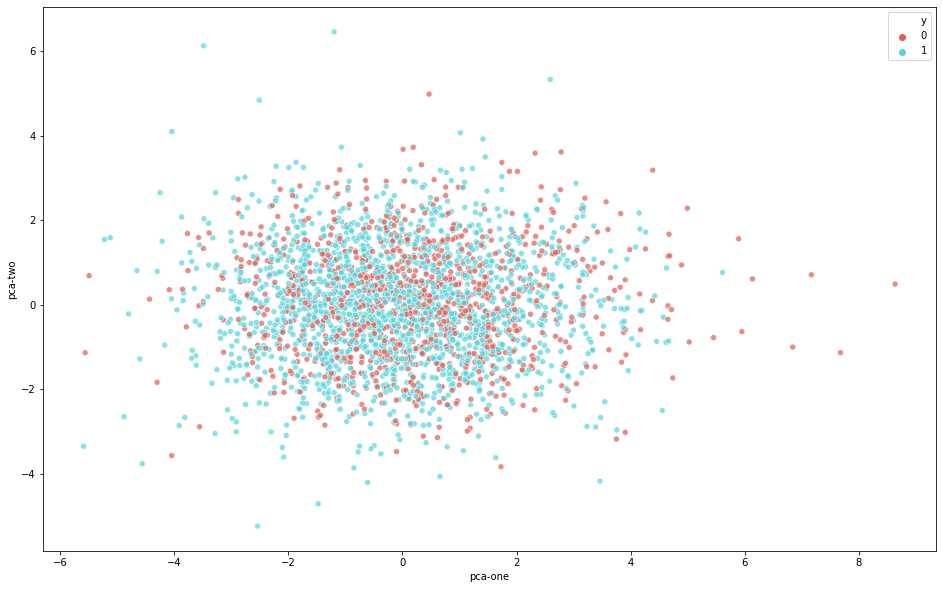

In [34]:
# For reproducability of the results
np.random.seed(42)
rndperm = np.random.permutation(df.shape[0])

plt.figure(figsize=(16,10))
sns.scatterplot(
    x="pca-one", y="pca-two",
    hue="y",
    palette=sns.color_palette("hls", 2),
    data=df.loc[rndperm,:],
    legend="full",
    alpha=0.7
)
plt.show()

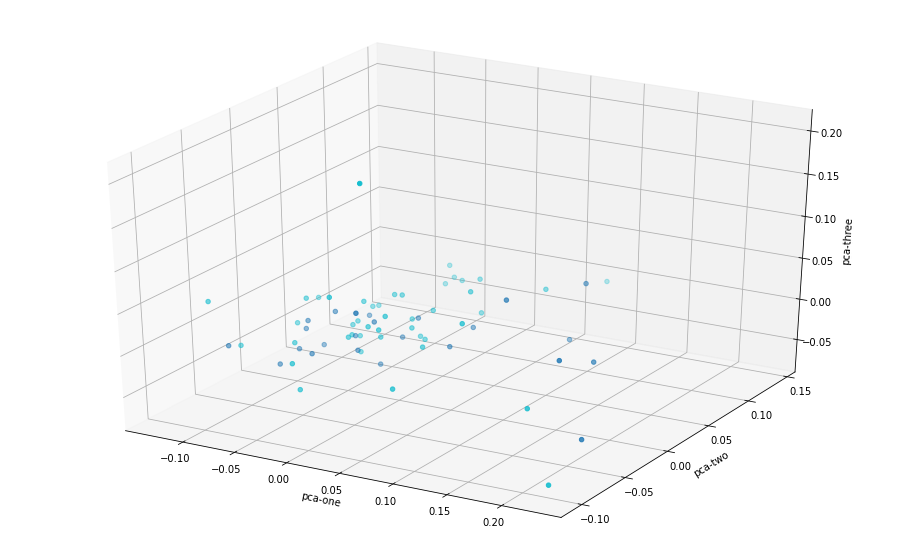

In [87]:
ax = plt.figure(figsize=(16,10)).gca(projection='3d')
ax.scatter(
    xs=df.loc[rndperm,:]["pca-one"], 
    ys=df.loc[rndperm,:]["pca-two"], 
    zs=df.loc[rndperm,:]["pca-three"], 
    c=df.loc[rndperm,:]["y"], 
    cmap='tab10'
)
ax.set_xlabel('pca-one')
ax.set_ylabel('pca-two')
ax.set_zlabel('pca-three')
plt.show()

Explained variation per principal component: [0.06051458 0.03381771 0.01539984]
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.392s...
[t-SNE] Computed neighbors for 10000 samples in 26.921s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 2.652192
[t-SNE] KL divergence after 250 iterations with early exaggeration: 119.273

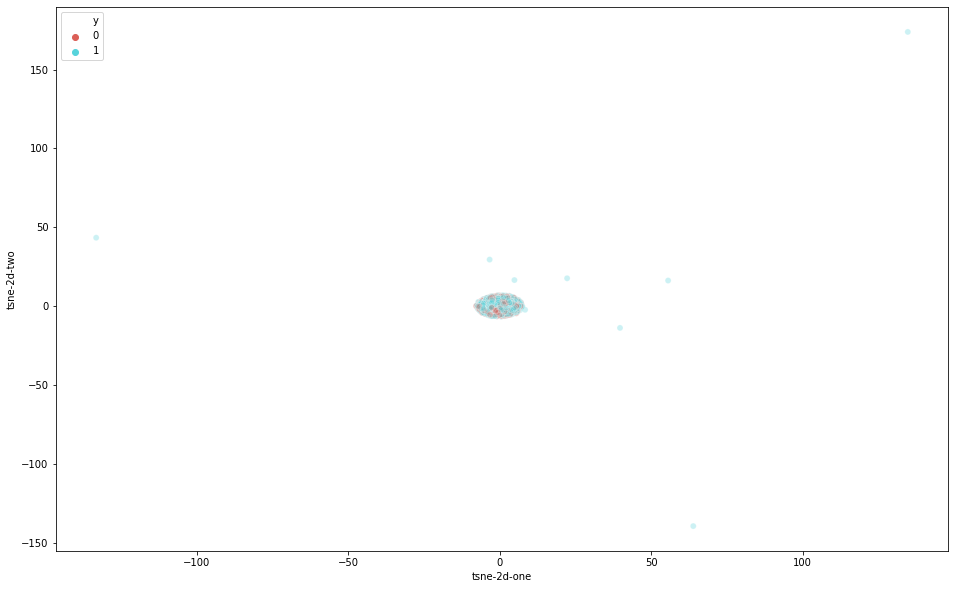

In [22]:
N = 10000
df_subset = df.loc[rndperm[:N],:].copy()
data_subset = df_subset[feat_cols].values
pca = PCA(n_components=3)
pca_result = pca.fit_transform(data_subset)
df_subset['pca-one'] = pca_result[:,0]
df_subset['pca-two'] = pca_result[:,1] 
df_subset['pca-three'] = pca_result[:,2]
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(data_subset)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

df_subset['tsne-2d-one'] = tsne_results[:,0]
df_subset['tsne-2d-two'] = tsne_results[:,1]
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="y",
    palette=sns.color_palette("hls", 2),
    data=df_subset,
    legend="full",
    alpha=0.3
)
plt.show()

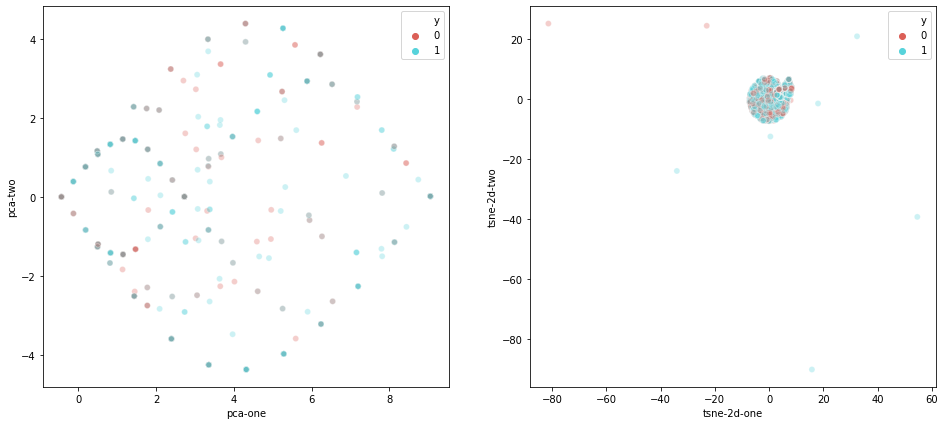

In [12]:
plt.figure(figsize=(16,7))
ax1 = plt.subplot(1, 2, 1)
sns.scatterplot(
    x="pca-one", y="pca-two",
    hue="y",
    palette=sns.color_palette("hls", 2),
    data=df_subset,
    legend="full",
    alpha=0.3,
    ax=ax1
)
ax2 = plt.subplot(1, 2, 2)
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="y",
    palette=sns.color_palette("hls", 2),
    data=df_subset,
    legend="full",
    alpha=0.3,
    ax=ax2
)
plt.show()

In [12]:
pca_50 = PCA(n_components=150)
pca_result_50 = pca_50.fit_transform(data_subset)
print('Cumulative explained variation for 50 principal components: {}'.format(np.sum(pca_50.explained_variance_ratio_)))

Cumulative explained variation for 50 principal components: 0.8099985985073128
